In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
from PIL import Image
from tqdm import tqdm
from scipy.signal import correlate2d
import cv2
from scipy import ndimage, datasets
import time

In [30]:
PATCH_SIZE = 7
HALF_SIZE = PATCH_SIZE // 2

PATCH_REGION = lambda i, j : (slice(i - HALF_SIZE, i + HALF_SIZE + 1), \
                              slice(j - HALF_SIZE, j + HALF_SIZE + 1))

SOBEL_X = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1],
])[:, :, np.newaxis]

SOBEL_Y = np.array([
    [1, 2, 1],
    [0, 0, 0],
    [-1, -2, -1],
])[:, :, np.newaxis]

def grad(img_pt):
    grad_x = np.sum(img_pt * SOBEL_X)
    grad_y = np.sum(img_pt * SOBEL_Y)

    gradient = np.array([grad_x, grad_y])
    norm = (np.linalg.norm(gradient))
    
    if norm > 0:
        unit_grad = gradient / norm
    else:
        unit_grad = gradient

    return unit_grad, norm

In [6]:
class MaskWithBoundary:
    def __init__(self, mask):
        self.array = mask
        self.init_boundary_pixels()

    def __getitem__(self, idx):
        return self.array[idx]

    def init_boundary_pixels(self):
        height, width = self.array.shape
        self.boundary_pixels = set()

        for i in range(height):
            for j in range(width):
                if self.array[i, j]: continue

                if i == 0 or i == height - 1 or j == 0 or j == width - 1:
                    self.boundary_pixels.add((i, j))

                elif self.array[i - 1, j] or self.array[i + 1, j] or self.array[i, j - 1] or self.array[i, j + 1]:
                    self.boundary_pixels.add((i, j))
        
    def update_boundary_pixels(self, i, j):
        # iterate through edges of patch centered at i, j
        for k in range(-HALF_SIZE, HALF_SIZE + 1):
            if not self.array[i + k, j - HALF_SIZE - 1]:
                self.boundary_pixels.add((i + k, j - HALF_SIZE - 1))
            if not self.array[i + k, j + HALF_SIZE + 1]:
                self.boundary_pixels.add((i + k, j + HALF_SIZE + 1))
            if not self.array[i - HALF_SIZE - 1, j + k]:
                self.boundary_pixels.add((i - HALF_SIZE - 1, j + k))
            if not self.array[i + HALF_SIZE + 1, j + k]:
                self.boundary_pixels.add((i + HALF_SIZE + 1, j + k))

    def fill_patch(self, i, j):
        patch_region = PATCH_REGION(i, j)
        idxs = [(i + y, j + x) for x in range(-HALF_SIZE, HALF_SIZE + 1) for y in range(-HALF_SIZE, HALF_SIZE + 1)]
        self.boundary_pixels -= set(idxs)
        
        self.array[patch_region] = True
        self.update_boundary_pixels(i, j)

    def empty(self):
        return len(self.boundary_pixels) == 0
    
    def render_boundary(self):
        mask_with_boundary = 255 * self.array.copy().astype(np.uint32)

        for (i, j) in self.boundary_pixels:
            mask_with_boundary[i, j] = 128

        plt.imshow(mask_with_boundary, cmap='grey')
        plt.show()

In [20]:
def overlay_mask_image(mask_with_boundary, image, pxs=[], show=True):
    mask_integer = mask_with_boundary.array.astype(np.uint8)
    mask_array = 255 * np.stack((mask_integer,) * 3, axis=-1)

    # Check if the image is grayscale (HxWx1) or RGB (HxWx3)
    if image.shape[-1] == 1:  # Grayscale
        rgb_image = np.stack((image.squeeze(),) * 3, axis=-1)  # Remove the last dimension and stack
    else:  # RGB
        rgb_image = np.copy(image)  # Make a copy of the image

    for (i, j) in pxs:
        rgb_image[i, j] = np.array([0, 0, 255])

    # Blend the image and the mask
    all_mask_pixels = [(i, j) for i in range(mask_array.shape[0]) for j in range(mask_array.shape[1]) if not mask_with_boundary[i, j]]
    interior_rows = [r for (r, _) in all_mask_pixels]
    interior_cols = [c for (_, c) in all_mask_pixels]
    rgb_image[interior_rows, interior_cols] = [255, 255, 255]

    boundary_pixels = list(mask_with_boundary.boundary_pixels)
    boundary_rows = [r for (r, _) in boundary_pixels]
    boundary_cols = [c for (_, c) in boundary_pixels]
    rgb_image[boundary_rows, boundary_cols] = [255, 0, 0]

    if show:
        plt.imshow(rgb_image.astype(np.uint32))
        plt.show()
    else:
        return rgb_image.astype(np.uint32)

In [37]:
class ObjectRemove:
    def __init__(self, patch_size, image):
        self.patch_size = patch_size
        self.patch_area = self.patch_size ** 2

        self.half_size = patch_size // 2
        self.image = image.astype(np.uint32).reshape((image.shape[0], image.shape[1], -1))
        self.height, self.width, self.channels = self.image.shape

        if self.channels == 1:
            self.luminance_image = self.image
            self.ALPHA = 255
        else:
            # TODO: use better RGB to grayscale conversion
            self.luminance_image = (np.sum(self.image, axis=-1) / 3).reshape((image.shape[0], image.shape[1], -1))
            self.ALPHA = 255

    def clamp_idx(self, ij):
        i, j = ij

        return [
            min(self.height - self.half_size - 1, max(self.half_size, i)),
            min(self.width - self.half_size - 1, max(self.half_size, j))
        ]

    def compute_priority(self, patch_coords, confidence_table, mask):
        i, j = patch_coords
        patch_region = PATCH_REGION(i, j)

        image_3filter = self.luminance_image[i-1:i+2, j-1:j+2]
        mask_3filter = mask[i-1:i+2, j-1:j+2][:, :, np.newaxis]

        confidence = np.sum(mask[patch_region] * confidence_table[patch_region], dtype=float)
        confidence /= self.patch_area

        (img_grad_x, img_grad_y), img_grad_norm = grad(image_3filter)
        boundary_normal, _boundary_grad_norm = grad(mask_3filter)
        
        isophote = img_grad_norm * np.array([-img_grad_y, img_grad_x])

        data = abs(np.dot(isophote, boundary_normal))
        data /= self.ALPHA

        return confidence, data
    
    def compute_distance(self, patch_coords, exemp_coords, mask):
        ip, jp = patch_coords
        ie, je = exemp_coords

        patch_region = PATCH_REGION(ip, jp)
        exemp_region = PATCH_REGION(ie, je)

        patch_mask = mask[patch_region][:, :, np.newaxis]

        patch_mask_sum = np.sum(patch_mask, dtype=float)
        patch_mask_not_sum = np.sum(~patch_mask, dtype=float)

        # compute MSD
        M_p = patch_mask * self.image[patch_region]
        M_e = patch_mask * self.image[exemp_region]

        msd = np.sum((M_p - M_e) ** 2, dtype=float)
        msd /= patch_mask_sum

        # compute SMD
        smd1 = np.sum(patch_mask * self.image[patch_region], dtype=float)
        smd2 = np.sum(~patch_mask * self.image[exemp_region], dtype=float)

        smd1 /= patch_mask_sum
        smd2 /= patch_mask_not_sum

        smd = (smd1 - smd2) ** 2

        return msd + smd

    def fill_region(self, mask, n_exemplar_samples=10):
        assert mask.array.shape[0] == self.image.shape[0] and mask.array.shape[1] == self.image.shape[1]
        max_dim = max(self.image.shape)

        frame_sequence = []
        fig, ax = plt.subplots()
        im = ax.imshow(overlay_mask_image(mask, self.image, show=False), cmap='viridis', interpolation='none')
            
        timing_specs = {
            'priorities': [0, 0],
            'exemplar': [0, 0],
            'fill': [0, 0],
        }

        # initialize confidence table to 0 for masked pixels, 1 for unmasked pixels
        confidence_table = mask.array.copy().astype(np.float32)
        n_iters = 0

        tot_n_tries = 0

        while not mask.empty():
            n_iters += 1

            start_time = time.time()

            priorities = {(i, j) : self.compute_priority((i, j), confidence_table, mask) for (i, j) in mask.boundary_pixels}
            ip, jp = max(priorities, key=lambda x: priorities[x][0] *  priorities[x][1])

            end_time = time.time()
            timing_specs['priorities'][1] = max(timing_specs['priorities'][1], end_time - start_time)
            timing_specs['priorities'][0] += end_time - start_time

            start_time = time.time()
            
            patch_region = PATCH_REGION(ip, jp)
            mask_region = mask[patch_region][:, :, np.newaxis] 

            max_confidence, _ = priorities[(ip, jp)]

            exemplar_distance = float('inf')
            exemplar_i, exemplar_j = None, None
            n_candidates = 0
            
            # Randomized search for exemplar patch
            n_tries = 0
            while n_candidates < 100:
                n_tries += 1
                s = 2
                offset = np.random.multivariate_normal([0, 0], [[max_dim / s, 0], [0, max_dim / s]])
                i, j = ip + int(offset[0]), jp + int(offset[1])
                
                ic, jc = self.clamp_idx((i, j))
                exemplar_region_c = PATCH_REGION(ic, jc)

                if np.sum(mask[exemplar_region_c]) == self.patch_area:
                    n_candidates += 1

                    c_exemplar_distance = self.compute_distance((ip, jp), (ic, jc), mask)
                    
                    if c_exemplar_distance < exemplar_distance:
                        exemplar_distance = c_exemplar_distance
                        exemplar_i, exemplar_j = ic, jc
            tot_n_tries += n_tries
            """
            # Brute force search for exemplar patch

            for i in range(self.half_size, self.height - self.half_size, 1):
                for j in range(self.half_size, self.width - self.half_size, 1):
                    r = PATCH_REGION(i, j)
                    if np.sum(mask[r], dtype=int) != self.patch_area: continue

                    c_exemplar_distance = self.compute_distance((ip, jp), (i, j), mask)

                    if c_exemplar_distance < exemplar_distance:
                        exemplar_distance = c_exemplar_distance
                        exemplar_i, exemplar_j = i, j"""

            end_time = time.time()
            timing_specs['exemplar'][1] = max(timing_specs['exemplar'][1], end_time - start_time)
            timing_specs['exemplar'][0] += end_time - start_time

            start_time = time.time()

            if self.channels == 3:
                self.image[patch_region] *=  mask_region
                self.image[patch_region] += ~mask_region * self.image[PATCH_REGION(exemplar_i, exemplar_j)]

                self.luminance_image[patch_region] *=  mask_region
                self.luminance_image[patch_region] += ~mask_region * self.luminance_image[PATCH_REGION(exemplar_i, exemplar_j)]
            else:
                self.image[patch_region] *=  mask_region
                self.image[patch_region] += ~mask_region * self.image[PATCH_REGION(exemplar_i, exemplar_j)]

            confidence_table[patch_region] *= mask_region[:, :, 0]
            confidence_table[patch_region] += ~mask_region[:, :, 0] * max_confidence

            mask.fill_patch(ip, jp)

            end_time = time.time()
            timing_specs['fill'][1] = max(timing_specs['fill'][1], end_time - start_time)
            timing_specs['fill'][0] += end_time - start_time

            # frame_sequence.append(overlay_mask_image(mask, self.image, show=False))

        # def update(frame):
        #     im.set_data(frame_sequence[frame])
        #     return [im]
        # ani = FuncAnimation(fig, update, frames=len(frame_sequence), blit=True)
        # ani.save('animation.gif', writer='imagemagick', fps=80)

        plt.imshow(self.image, cmap='gray')
        plt.title("Inpainted Image")
        plt.show()

        plt.imshow(confidence_table, cmap='gray')
        plt.title("Confidence Table")
        plt.show()

        print(tot_n_tries/n_iters)
        print(f"Timing stats over {n_iters} iterations:")
        for x in timing_specs:
            print(f"{x}: {timing_specs[x][0] / n_iters * 1e3} ms avg, {timing_specs[x][1] * 1e3} ms max")

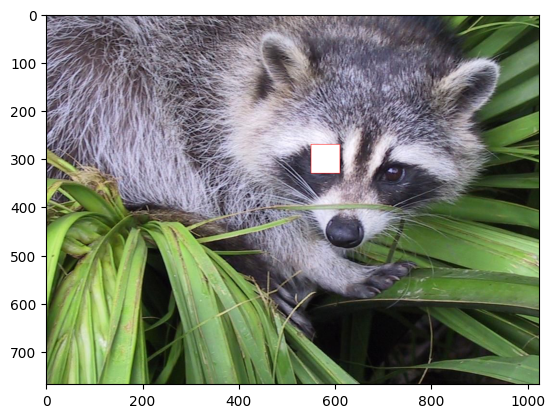

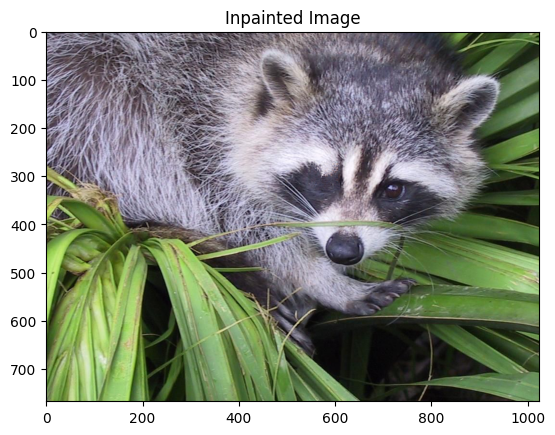

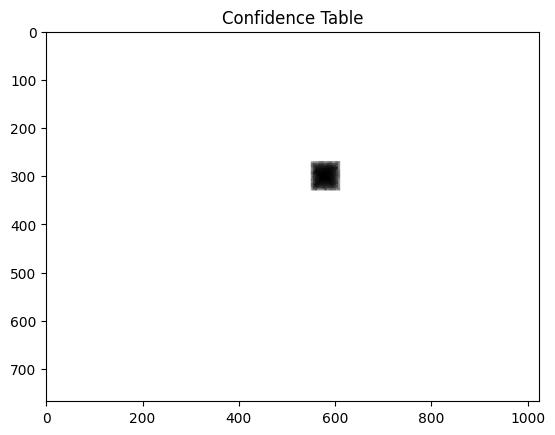

Timing stats over 204 iterations:
priorities: 3.9912707665387326 ms avg, 6.618022918701172 ms max
exemplar: 6.584584712982178 ms avg, 17.382144927978516 ms max
fill: 0.048596484988343486 ms avg, 0.29730796813964844 ms max


In [38]:
# image = (255 * np.ones((128, 128), dtype=int)).reshape((128, 128, -1))
# for i in range(image.shape[0]):
#     for j in range(image.shape[1]):
#         if (i + 2 * j >= 170):
#             image[i, j] = 0

image = datasets.face().astype('int32')

mask = np.ones((image.shape[0], image.shape[1]), dtype=bool)
box_w, box_h = 60, 60
mask[300-box_h//2 : 300+box_h//2+1, 580-box_w//2 : 580+box_w//2+1] = False
mask_with_boundary = MaskWithBoundary(mask)

overlay_mask_image(mask_with_boundary, image)

objrem = ObjectRemove(PATCH_SIZE, image)
objrem.fill_region(mask_with_boundary)